In [3]:
import eli5
from eli5.sklearn import PermutationImportance
import lime,shap
import xgboost as xgb
import lightgbm as lgb
import sklearn
import numpy as np
import pandas as pd
import sklearn.ensemble
import sklearn.metrics
from sklearn.datasets import load_iris
from lime.lime_tabular import LimeTabularExplainer
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split

from collections import defaultdict

import matplotlib.pyplot as plt

from scipy.stats import spearmanr
from scipy.cluster import hierarchy

from sklearn.inspection import permutation_importance

/Users/linxi/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/linxi/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [5]:
feature_names = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital Status","Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss","Hours per week", "Country"]
data = np.genfromtxt('data/adult.data', delimiter=', ', dtype=str)
data = pd.DataFrame(data, columns=feature_names+['label'])

In [7]:
data.describe()

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,label
count,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,73,9,21648,16,16,7,15,6,5,2,119,92,94,42,2
top,36,Private,123011,HS-grad,9,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,<=50K
freq,898,22696,13,10501,10501,14976,4140,13193,27816,21790,29849,31042,15217,29170,24720


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
Age               32561 non-null object
Workclass         32561 non-null object
fnlwgt            32561 non-null object
Education         32561 non-null object
Education-Num     32561 non-null object
Marital Status    32561 non-null object
Occupation        32561 non-null object
Relationship      32561 non-null object
Race              32561 non-null object
Sex               32561 non-null object
Capital Gain      32561 non-null object
Capital Loss      32561 non-null object
Hours per week    32561 non-null object
Country           32561 non-null object
label             32561 non-null object
dtypes: object(15)
memory usage: 3.7+ MB


In [47]:
data.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [8]:
labels = 1*(data['label'] == '>50K')
class_names = ['<=50K', '>50K']
# data = data[:,:-1]

categorical_features = [1,3,5, 6,7,8,9,13]

categorical_names = {}
for feature in categorical_features:
    le = LabelEncoder()
    le.fit(data.iloc[:, feature])
    data.iloc[:, feature] = le.transform(data.iloc[:, feature])
    categorical_names[feature] = le.classes_
    
data[feature_names] = data[feature_names].astype(float)

In [9]:
np.random.seed(1)
train_x, val_x, train_y, val_y = train_test_split(data[feature_names], labels, train_size=0.80)

# encoder.fit(data)
# encoded_train = encoder.transform(train)
# encoded_test = encoder.transform(test)

clf = xgb.XGBClassifier(n_estimators=2000, max_depth=4, learning_rate=0.05, n_jobs=8)
clf.fit(train_x, train_y, eval_set=[(val_x, val_y)], eval_metric='auc', verbose=100, early_stopping_rounds=100)

[0]	validation_0-auc:0.868147
Will train until validation_0-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.914365
[200]	validation_0-auc:0.921417
[300]	validation_0-auc:0.92369
[400]	validation_0-auc:0.924009
[500]	validation_0-auc:0.924338
[600]	validation_0-auc:0.924608
[700]	validation_0-auc:0.924968
[800]	validation_0-auc:0.92494
Stopping. Best iteration:
[749]	validation_0-auc:0.925074



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=2000, n_jobs=8,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

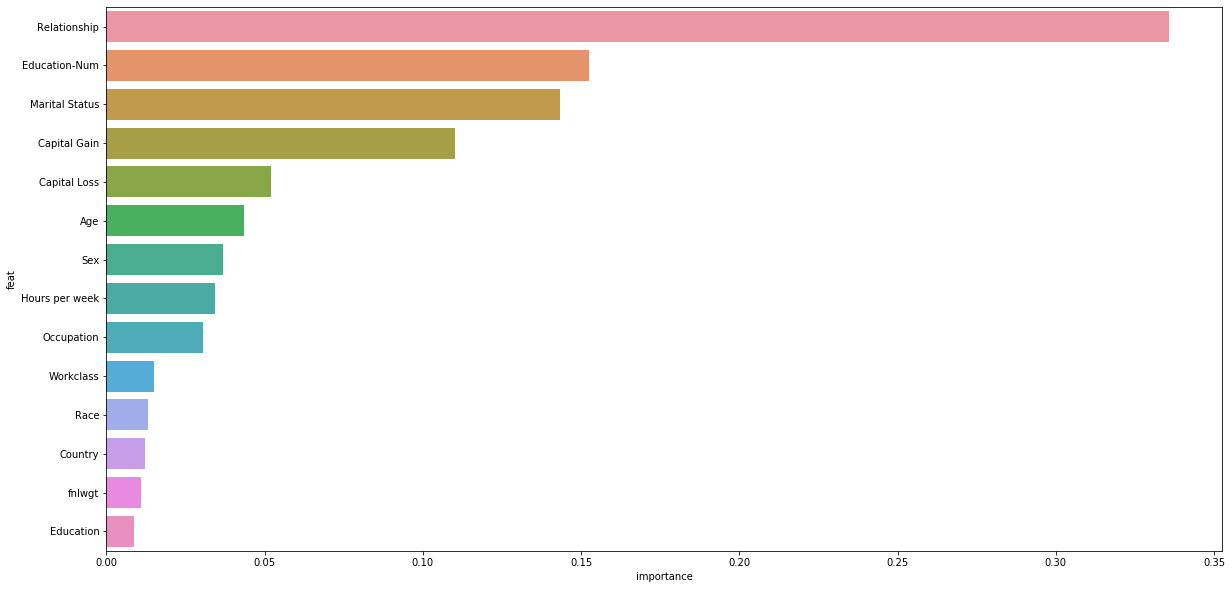

In [10]:
import seaborn as sns
from sklearn.inspection import permutation_importance

def plot_featImp(feature, lgb_model):
    """
    绘制特征的重要性
    input:
        feature：特征
        lgb_model:训练后的模型
    """
    featImp = pd.DataFrame()
    featImp['feat'] = feature
    featImp['importance'] = lgb_model.feature_importances_ 
    featImp = featImp.sort_values('importance',ascending = False)

    plt.figure(figsize=[20,10])
    sns.barplot(x = 'importance', y ='feat',data = featImp[:20],orient='h')
    plt.show
    
plot_featImp(feature_names,clf)

<function matplotlib.pyplot.show(*args, **kw)>

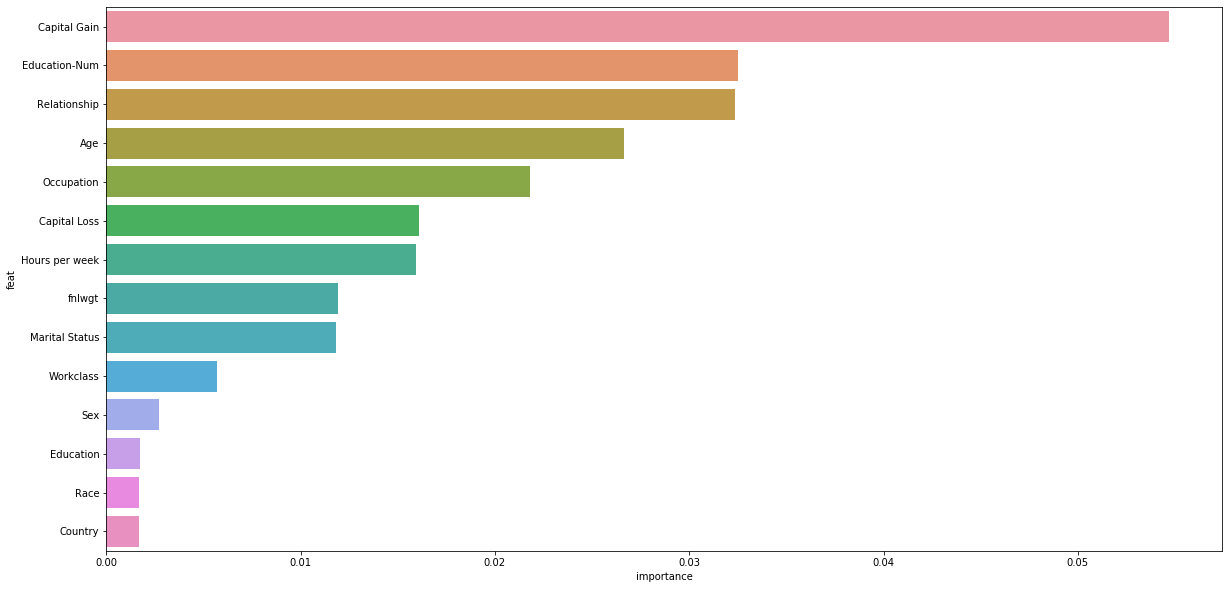

In [12]:
result = permutation_importance(clf, train_x, train_y, n_repeats=10,random_state=42)
featImp = pd.DataFrame()
featImp['feat'] = feature_names
featImp['importance'] = result.importances_mean
featImp = featImp.sort_values('importance',ascending = False)

plt.figure(figsize=[20,10])
sns.barplot(x = 'importance', y = 'feat',data = featImp[:20],orient='h')
plt.show

In [20]:
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(clf, n_iter=10)
perm.fit(train_x, train_y)
eli5.show_weights(perm, feature_names=train_x.columns.tolist())

Weight,Feature
0.0533 ± 0.0024,Capital Gain
0.0332 ± 0.0024,Education-Num
0.0296 ± 0.0021,Relationship
0.0260 ± 0.0014,Age
0.0213 ± 0.0027,Occupation
0.0152 ± 0.0010,Capital Loss
0.0147 ± 0.0017,Hours per week
0.0112 ± 0.0013,Marital Status
0.0106 ± 0.0016,fnlwgt
0.0053 ± 0.0012,Workclass


In [15]:
train_x.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
16465,39.0,6.0,188571.0,1.0,7.0,2.0,14.0,0.0,4.0,1.0,0.0,0.0,40.0,39.0
5625,54.0,6.0,105010.0,9.0,13.0,2.0,4.0,0.0,4.0,1.0,0.0,0.0,40.0,39.0
30273,32.0,4.0,156464.0,11.0,9.0,2.0,12.0,0.0,4.0,1.0,0.0,1902.0,50.0,39.0
3136,45.0,6.0,32172.0,15.0,10.0,4.0,5.0,1.0,4.0,1.0,0.0,0.0,50.0,39.0
4521,60.0,4.0,146674.0,0.0,6.0,2.0,6.0,0.0,2.0,1.0,0.0,0.0,40.0,39.0


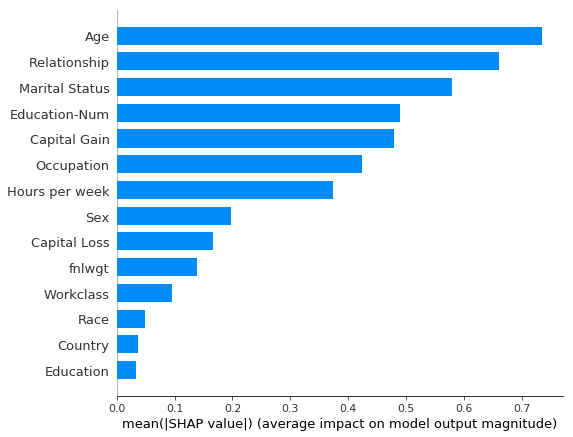

In [53]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(val_x)

# 对一个样本求shap值，各个特征对output所带来的变化
shap.summary_plot(shap_values, val_x, plot_type='bar')

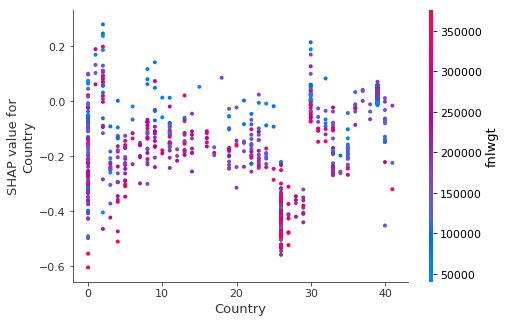

In [10]:
shap.dependence_plot("Country", shap_values, val_x)